# SMI AL Loop

In [1]:
import h5py
import time
import random
import datetime
import copy
import numpy as np
import os
import csv
import json
import subprocess
import sys
import PIL.Image as Image
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from cords.cords.selectionstrategies.supervisedlearning import DataSelectionStrategy
# from cords.cords.utils.models import ResNet18
from distil.distil.utils.models.resnet import ResNet18
from gable.gable.utils.models import MobileNetV2
from gable.gable.utils.custom_dataset import load_dataset_custom
from torch.utils.data import Subset
from torch.autograd import Variable
import tqdm
from math import floor
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from distil.distil.active_learning_strategies import BADGE, EntropySampling, GLISTER, GradMatchActive, CoreSet, LeastConfidence, MarginSampling 
from distil.distil.utils.DataHandler import DataHandler_CIFAR10, DataHandler_MNIST

seed=42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed) 
# for cuda
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.enabled = False

In [35]:
data_dir = "/home/snk170001/research/data/custom/bc_train_test"
input_size=224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

fullset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
testset = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
print(len(fullset))
print(len(testset))
for i in range(4): #all_classes
    full_idx_class = list(torch.where(torch.Tensor(fullset.targets) == i)[0].cpu().numpy())
    print("train: " + str(i) , len(full_idx_class))
    full_idx_class = list(torch.where(torch.Tensor(testset.targets) == i)[0].cpu().numpy())
    print("test: " + str(i) , len(full_idx_class))

2420
639
train: 0 354
test: 0 65
train: 1 932
test: 1 260
train: 2 734
test: 2 201
train: 3 400
test: 3 113


In [46]:
X = []
for i in range(len(fullset)):
    X.append(fullset[i][0].tolist())
print(X[0])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [54]:
from PIL import Image
X = np.array(X)
# print(X[0])
X_r = X.transpose(0,2,3,1)
 

(3, 224, 224)


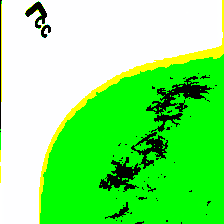

In [58]:
# X = X.astype(np.int)
print(X[0].shape)
Image.fromarray((X_r[0]).astype(np.uint8))

In [2]:
from torch.utils.data import Dataset
class custom_subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
        labels(sequence) : targets as required for the indices. will be the same length as indices
    """
    def __init__(self, dataset, indices, labels):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.targets = labels.type(torch.long)
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        target = self.targets[idx]
        return (image, target)

    def __len__(self):
        return len(self.targets)

In [17]:
class DataHandler_Medical(Dataset):
    def __init__(self, X, Y=None, select=True, use_test_transform = False):
        self.select = select
        self.use_test_transform=use_test_transform
        self.training_gen_transform = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        self.test_gen_transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        if not self.select:
            self.X = X
            self.Y = Y
        else:
            self.X = X

    def __getitem__(self, index):
        if not self.select:
            x, y = self.X[index], self.Y[index]
            x = Image.fromarray(x)
            if self.use_test_transform:
                x = self.test_gen_transform(x)
            else:
                x = self.training_gen_transform(x)
            return x, y, index

        else:
            x = self.X[index]
            x = Image.fromarray(x)
            if self.use_test_transform:
                x = self.test_gen_transform(x)
            else:
                x = self.training_gen_transform(x)
            return x, index

    def __len__(self):
        return len(self.X)
    
def __init__(self, X, Y=None, select=True, use_test_transform=False):
        """
        Constructor
        """
        self.select = select
        self.use_test_transform=use_test_transform
        self.training_gen_transform = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        self.test_gen_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # ImageNet mean/std
        if not self.select:
            self.X = X
            self.Y = Y
        else:
            self.X = X

    

In [18]:
def model_eval_loss(data_loader, model, criterion):
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss

def init_weights(m):
#     torch.manual_seed(35)
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
                
def create_model(name, num_cls, device):
    if name == 'ResNet18':
        model = ResNet18(num_cls)
    elif name == 'MnistNet':
        model = MnistNet()
    elif name == 'ResNet164':
        model = ResNet164(num_cls)
    elif name == 'MobileNetV2':
        model = MobileNetV2(num_cls)
#         model = models.mobilenet_v2(pretrained=True)
#         model.classifier = nn.Sequential(
#             nn.Dropout(0.2),
#             nn.Linear(model.last_channel, num_cls),
#         ) 
    model.apply(init_weights)
    model = model.to(device)
    return model

def loss_function():
    criterion = nn.CrossEntropyLoss()
    criterion_nored = nn.CrossEntropyLoss(reduction='none')
    return criterion, criterion_nored

def optimizer_with_scheduler(model, num_epochs, learning_rate, m=0.9, wd=5e-4):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                          momentum=m, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    return optimizer, scheduler

def optimizer_without_scheduler(model, learning_rate, m=0.9, wd=5e-4):
#     optimizer = optim.Adam(model.parameters(),weight_decay=wd)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                          momentum=m, weight_decay=wd)
    return optimizer

def generate_cumulative_timing(mod_timing):
    tmp = 0
    mod_cum_timing = np.zeros(len(mod_timing))
    for i in range(len(mod_timing)):
        tmp += mod_timing[i]
        mod_cum_timing[i] = tmp
    return mod_cum_timing/3600

def kernel(x, y, measure="cosine", exp=2):
    if(measure=="eu_sim"):
        dist = pairwise_distances(x.cpu().numpy(), y.cpu().numpy())
        sim = max(dist.ravel()) - dist
#         n = x.size(0)
#         m = y.size(0)
#         d = x.size(1)
#         x = x.unsqueeze(1).expand(n, m, d)
#         y = y.unsqueeze(0).expand(n, m, d)
#         dist = torch.pow(x - y, exp).sum(2)
#         const = torch.max(dist).item()
#         sim = (const - dist)
    
        #dist = torch.exp(-1 * torch.pow(x - y, 2).sum(2))
    if(measure=="cosine"):
        sim = cosine_similarity(x.cpu().numpy(), y.cpu().numpy())
    return sim


def save_kernel_hdf5(lake_kernel, lake_target_kernel, target_kernel=[], lake_private_kernel=[], pp_kernel=[], numpy=True):
    if(not(numpy)):
        lake_kernel = lake_kernel.cpu().numpy()
    with h5py.File("smi_lake_kernel_" + device.split(":")[1] +".hdf5", 'w') as hf:
        hf.create_dataset("kernel",  data=lake_kernel)
    if(not(numpy)):
        lake_target_kernel = lake_target_kernel.cpu().numpy()
    with h5py.File("smi_lake_target_kernel_" + device.split(":")[1] + ".hdf5", 'w') as hf:
        hf.create_dataset("kernel",  data=lake_target_kernel)
    if(not(numpy)):
        target_kernel = target_kernel.cpu().numpy()
    with h5py.File("smi_target_kernel_" + device.split(":")[1] + ".hdf5", 'w') as hf:
        hf.create_dataset("kernel",  data=target_kernel)
    if(not(numpy)):
        lake_private_kernel = lake_private_kernel.cpu().numpy()
    with h5py.File("smi_lake_private_kernel_" + device.split(":")[1] + ".hdf5", 'w') as hf:
        hf.create_dataset("kernel",  data=lake_private_kernel)
    if(not(numpy)):
        pp_kernel = pp_kernel.cpu().numpy()
    with h5py.File("smi_pp_kernel_" + device.split(":")[1] + ".hdf5", 'w') as hf:
        hf.create_dataset("kernel",  data=pp_kernel)
            
def find_err_per_class(test_set, val_set, final_val_classifications, final_val_predictions, final_tst_classifications, 
                       final_tst_predictions, saveDir, prefix):
    #find queries from the validation set that are erroneous
#     saveDir = os.path.join(saveDir, prefix)
#     if(not(os.path.exists(saveDir))):
#         os.mkdir(saveDir)
    val_err_idx = list(np.where(np.array(final_val_classifications) == False)[0])
    tst_err_idx = list(np.where(np.array(final_tst_classifications) == False)[0])
    val_class_err_idxs = []
    tst_err_log = []
    val_err_log = []
    for i in range(num_cls):
        tst_class_idxs = list(torch.where(torch.Tensor(test_set.targets) == i)[0].cpu().numpy())
        val_class_idxs = list(torch.where(torch.Tensor(val_set.targets.float()) == i)[0].cpu().numpy())
        #err classifications per class
        val_err_class_idx = set(val_err_idx).intersection(set(val_class_idxs))
        tst_err_class_idx = set(tst_err_idx).intersection(set(tst_class_idxs))
        if(len(val_class_idxs)>0):
            val_error_perc = round((len(val_err_class_idx)/len(val_class_idxs))*100,2)
        else:
            val_error_perc = 0
        tst_error_perc = round((len(tst_err_class_idx)/len(tst_class_idxs))*100,2)
        print("val, test error% for class ", i, " : ", val_error_perc, tst_error_perc)
        val_class_err_idxs.append(val_err_class_idx)
        tst_err_log.append(tst_error_perc)
        val_err_log.append(val_error_perc)
    tst_err_log.append(sum(tst_err_log)/len(tst_err_log))
    val_err_log.append(sum(val_err_log)/len(val_err_log))
    return tst_err_log, val_err_log, val_class_err_idxs


def aug_train_subset(train_set, lake_set, true_lake_set, subset, lake_subset_idxs, budget, augrandom=False):
    all_lake_idx = list(range(len(lake_set)))
    if(not(len(subset)==budget) and augrandom):
        print("Budget not filled, adding ", str(int(budget) - len(subset)), " randomly.")
        remain_budget = int(budget) - len(subset)
        remain_lake_idx = list(set(all_lake_idx) - set(subset))
        random_subset_idx = list(np.random.choice(np.array(remain_lake_idx), size=int(remain_budget), replace=False))
        subset += random_subset_idx
    lake_ss = custom_subset(true_lake_set, subset, torch.Tensor(true_lake_set.targets.float())[subset])
    if(feature=="ood"): 
        ood_lake_idx = list(set(lake_subset_idxs)-set(subset))
        private_set =  custom_subset(true_lake_set, ood_lake_idx, torch.Tensor(np.array([split_cfg['num_cls_idc']]*len(ood_lake_idx))).float())
    remain_lake_idx = list(set(all_lake_idx) - set(lake_subset_idxs))
    remain_lake_set = custom_subset(lake_set, remain_lake_idx, torch.Tensor(lake_set.targets.float())[remain_lake_idx])
    remain_true_lake_set = custom_subset(true_lake_set, remain_lake_idx, torch.Tensor(true_lake_set.targets.float())[remain_lake_idx])
    print(len(lake_ss),len(remain_lake_set),len(lake_set))
    if(feature!="ood"): assert((len(lake_ss)+len(remain_lake_set))==len(lake_set))
    aug_train_set = torch.utils.data.ConcatDataset([train_set, lake_ss])
    if(feature=="ood"): 
        return aug_train_set, remain_lake_set, remain_true_lake_set, private_set, lake_ss
    else:
        return aug_train_set, remain_lake_set, remain_true_lake_set
                        
def getMisclsSet(val_set, val_class_err_idxs, imb_cls_idx):
    miscls_idx = []
    for i in range(len(val_class_err_idxs)):
        if i in imb_cls_idx:
            miscls_idx += val_class_err_idxs[i]
    print("total misclassified ex from imb classes: ", len(miscls_idx))
    return Subset(val_set, miscls_idx)

def getMisclsSetNumpy(X_val, y_val, val_class_err_idxs, imb_cls_idx):
    miscls_idx = []
    for i in range(len(val_class_err_idxs)):
        if i in imb_cls_idx:
            miscls_idx += val_class_err_idxs[i]
    print("total misclassified ex from imb classes: ", len(miscls_idx))
    return X_val[miscls_idx], y_val[miscls_idx]

def getPrivateSet(lake_set, subset, private_set):
    #augment prev private set and current subset
    new_private_set = custom_subset(lake_set, subset, torch.Tensor(lake_set.targets.float())[subset])
#     new_private_set =  Subset(lake_set, subset)
    total_private_set = torch.utils.data.ConcatDataset([private_set, new_private_set])
    return total_private_set

def getSMI_ss(datkbuildPath, exePath, hdf5Path, budget, numQueries, sf):
    if(sf=="fl1mi"):
        command = os.path.join(datkbuildPath, exePath) + " -mode query -naiveOrRandom naive -magnificationLambda 1 -numSummaries 1 -budget " + str(budget) + " -queryPrivacyOptimizer " + sf + " -numQueries " + numQueries + " -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path, "smi_lake_kernel_"+str(device).split(":")[1]+".hdf5") +  " -queryKernelFile " + os.path.join(hdf5Path, "smi_lake_target_kernel_"+str(device).split(":")[1]+".hdf5")
    elif(sf == "logdetmi"):
        command = os.path.join(datkbuildPath, "cifarSubsetSelector_ng") + " -mode query -naiveOrRandom naive -logDetLambda 1 -magnificationLambda 1 -numSummaries 1 -budget " + str(budget) + " -queryPrivacyOptimizer " + sf + " -numQueries  " + numQueries + "  -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path, "smi_lake_kernel_"+str(device).split(":")[1]+".hdf5") + " -queryKernelFile " + os.path.join(hdf5Path, "smi_lake_target_kernel_"+str(device).split(":")[1]+".hdf5") + " -queryqueryKernelFile " + os.path.join(hdf5Path, "smi_target_kernel_"+str(device).split(":")[1]+".hdf5")
    elif(sf=="fl2mi"):
        command = os.path.join(datkbuildPath, exePath) + " -mode query -naiveOrRandom naive -queryDiversityLambda 1 -magnificationLambda 1 -numSummaries 1 -budget " + str(budget) + " -queryPrivacyOptimizer " + sf + " -numQueries  " + numQueries + " -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path, "smi_lake_kernel_"+str(device).split(":")[1]+".hdf5") + " -queryKernelFile " + os.path.join(hdf5Path, "smi_lake_target_kernel_"+str(device).split(":")[1]+".hdf5")
    elif(sf=="gcmi" or sf=="div-gcmi"):
        command = os.path.join(datkbuildPath, exePath) + " -mode query -naiveOrRandom naive -magnificationLambda 1 -numSummaries 1 -budget " + str(budget) + " -queryPrivacyOptimizer " + sf + " -numQueries " + numQueries + " -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path,"smi_lake_kernel_"+str(device).split(":")[1]+".hdf5") + " -queryKernelFile " + os.path.join(hdf5Path,"smi_lake_target_kernel_"+str(device).split(":")[1]+".hdf5")
    elif(sf=="gccg"):
        command = os.path.join(datkbuildPath, exePath) + " -mode private -naiveOrRandom naive -gcLambda 1 -magnificationLambda 1 -numSummaries 1 -budget " + str(budget) + " -queryPrivacyOptimizer " + sf + " -numPrivates " + numQueries + " -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path,"smi_lake_kernel_"+str(device).split(":")[1]+".hdf5") + " -privateKernelFile " + os.path.join(hdf5Path,"smi_lake_target_kernel_"+str(device).split(":")[1]+".hdf5")
    elif(sf=="fl1cg"):
        command = os.path.join(datkbuildPath, exePath) + " -mode private -naiveOrRandom naive -magnificationLambda 1 -numSummaries 1 -budget " + str(budget) + " -queryPrivacyOptimizer " + sf + " -numPrivates " + numQueries + " -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path,"smi_lake_kernel_"+str(device).split(":")[1]+".hdf5") + " -privateKernelFile " + os.path.join(hdf5Path,"smi_lake_target_kernel_"+str(device).split(":")[1]+".hdf5")
    elif(sf=="logdetcg"):
        command = os.path.join(datkbuildPath, exePath) + " -mode private -naiveOrRandom naive -magnificationLambda 1 -numSummaries 1 -budget " + str(budget) + " -queryPrivacyOptimizer " + sf + " -numPrivates " + numQueries + " -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path,"smi_lake_kernel_"+str(device).split(":")[1]+".hdf5") + " -privateKernelFile " + os.path.join(hdf5Path,"smi_lake_target_kernel_"+str(device).split(":")[1]+".hdf5") + " -privateprivateKernelFile " + os.path.join(hdf5Path, "smi_target_kernel_"+str(device).split(":")[1]+".hdf5")
    elif(sf=="fl" or sf=="logdet"):
        command = os.path.join(datkbuildPath, "cifarSubsetSelector_ng") + " -mode generic -naiveOrRandom naive -logDetLambda 1 -numSummaries 1 -budget " + str(budget) + " -genericOptimizer " + sf + " -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path,"smi_lake_kernel_"+str(device).split(":")[1]+".hdf5")
    elif(sf =="gc"):
        command = os.path.join(datkbuildPath, exePath) + " -mode generic -naiveOrRandom naive -gcLambda 1 -numSummaries 1 -budget " + str(budget) + " -genericOptimizer " + sf + " -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path,"smi_lake_kernel_"+str(device).split(":")[1]+".hdf5")
    elif(sf =="dsum"):
        command = os.path.join(datkbuildPath, exePath) + " -mode generic -naiveOrRandom naive -gcLambda 1 -numSummaries 1 -budget " + str(budget) + " -genericOptimizer " + sf + " -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path,"smi_lake_kernel_"+str(device).split(":")[1]+".hdf5")
    print("Executing SIM command: ", command)
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=True, shell=True)
    subset = process.communicate()[0]
    subset = subset.decode("utf-8")
    subset = subset.strip().split(" ")
    subset = list(map(int, subset))
    return subset

def getCMI_ss(datkbuildPath, exePath, hdf5Path, budget, numQueries, numPrivates, sf):
    if(sf=="flmic"):
        command = os.path.join(datkbuildPath, exePath) + " -mode joint -naiveOrRandom naive -magnificationLambda 1 -numSummaries 1 -budget " + str(budget) + " -queryPrivacyOptimizer " + sf + " -numQueries " + numQueries + " -numPrivates " + numPrivates + " -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path, "smi_lake_kernel_"+str(device).split(":")[1]+".hdf5") +  " -queryKernelFile " + os.path.join(hdf5Path, "smi_lake_target_kernel_"+str(device).split(":")[1]+".hdf5") + " -privateKernelFile " + os.path.join(hdf5Path,"smi_lake_private_kernel_"+str(device).split(":")[1]+".hdf5")
    if(sf == "logdetmic"):
        command = os.path.join(datkbuildPath, exePath) + " -mode joint -naiveOrRandom naive -magnificationLambda 1 -numSummaries 1 -budget " + str(budget) + " -queryPrivacyOptimizer " + sf + " -numQueries " + numQueries + " -numPrivates " + numPrivates + " -dontComputeKernel true -imageKernelFile " + os.path.join(hdf5Path, "smi_lake_kernel_"+str(device).split(":")[1]+".hdf5") +  " -queryKernelFile " + os.path.join(hdf5Path, "smi_lake_target_kernel_"+str(device).split(":")[1]+".hdf5") + " -privateKernelFile " + os.path.join(hdf5Path,"smi_lake_private_kernel_"+str(device).split(":")[1]+".hdf5")
    
    print("Executing CMI command: ", command)
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=True, shell=True)
    subset = process.communicate()[0]
    subset = subset.decode("utf-8")
    subset = subset.strip().split(" ")
    subset = list(map(int, subset))
    return subset

def remove_ood_points(lake_set, subset, idc_idx):
    idx_subset = []
    subset_cls = torch.Tensor(lake_set.targets.float())[subset]
    for i in idc_idx:
        idc_subset_idx = list(torch.where(subset_cls == i)[0].cpu().numpy())
        idx_subset += list(np.array(subset)[idc_subset_idx])
    print(len(idx_subset),"/",len(subset), " idc points.")
    return idx_subset

def getPerClassSel(lake_set, subset, num_cls):
    perClsSel = []
    subset_cls = torch.Tensor(lake_set.targets.float())[subset]
    for i in range(num_cls):
        cls_subset_idx = list(torch.where(subset_cls == i)[0].cpu().numpy())
        perClsSel.append(len(cls_subset_idx))
    return perClsSel

#check overlap with prev selections
def check_overlap(prev_idx, prev_idx_hist, idx):
    prev_idx = [int(x/num_rep) for x in prev_idx]
    prev_idx_hist = [int(x/num_rep) for x in prev_idx_hist]
    idx = [int(x/num_rep) for x in idx]
    # overlap = set(prev_idx).intersection(set(idx))
    overlap = [value for value in idx if value in prev_idx] 
    # overlap_hist = set(prev_idx_hist).intersection(set(idx))
    overlap_hist = [value for value in idx if value in prev_idx_hist]
    new_points = set(idx) - set(prev_idx_hist)
    total_unique_points = set(idx+prev_idx_hist)
    print("New unique points: ", len(new_points))
    print("Total unique points: ", len(total_unique_points))
    print("overlap % of sel with prev idx: ", len(overlap)/len(idx))
    print("overlap % of sel with all prev idx: ", len(overlap_hist)/len(idx))
    return len(overlap)/len(idx), len(overlap_hist)/len(idx)

def getFeatures(model, dataloader):
    pass

In [35]:
datadir = 'data/'
data_name = 'breast_density'
num_cls=4
fraction = float(0.1)
budget=50
num_epochs = int(20)
num_rep = 10
model_name = 'MobileNetV2'
learning_rate = 0.01
feature = 'classimb'
split_cfg = {"sel_cls_idx":[0,3], "per_imbclass_train":{0:35,3:40}, "per_imbclass_val":{0:10,3:10}, "per_imbclass_lake":{0:309,3:350}, "per_class_train":{1:93,2:73}, "per_class_val":{1:10,2:10}, "per_class_lake":{1:829,2:651}} #cifar10
initModelPath = "weights/"+data_name + "_" + model_name + "_" + str(learning_rate) + "_" + str(split_cfg["per_imbclass_train"]) + "_" + str(split_cfg["per_class_train"])
num_runs = 1  # number of random runs
computeClassErrorLog = True
run=2
magnification = 1
device = "cuda:1" if torch.cuda.is_available() else "cpu"
datkbuildPath = "/home/snk170001/bioml/dss/notebooks/datk/build"
exePath = "cifarSubsetSelector"
print("Using Device:", device)
doublePrecision = True
linearLayer = True
handler = DataHandler_Medical


Using Device: cuda:1


# AL Like Train Loop

In [29]:
def train_model_al(datkbuildPath, exePath, num_epochs, dataset_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run,
                device, computeErrorLog, strategy="SIM", sf=""):
#     torch.manual_seed(42)
#     np.random.seed(42)
    print(strategy, sf)
    #load the dataset based on type of feature
    if(feature=="classimb" or feature=="ood"):
        if(strategy == "SIM" or strategy == "SF" or strategy=="random"):
            if(strategy == "SF" or strategy=="random"):
                train_set, val_set, test_set, lake_set, sel_cls_idx, num_cls = load_dataset_custom(datadir, dataset_name, feature, split_cfg, False, True)
            else:
                train_set, val_set, test_set, lake_set, sel_cls_idx, num_cls = load_dataset_custom(datadir, dataset_name, feature, split_cfg, False, False)
        elif(strategy=="AL"):
            if(sf=="badge" or sf=="us"):
                X_tr, y_tr, X_val, y_val, X_unlabeled, y_unlabeled, train_set, val_set, test_set, lake_set, sel_cls_idx, num_cls = load_dataset_custom(datadir, dataset_name, feature, split_cfg, True, False)
            else: #dont augment train with valid
                X_tr, y_tr, X_val, y_val, X_unlabeled, y_unlabeled, train_set, val_set, test_set, lake_set, sel_cls_idx, num_cls = load_dataset_custom(datadir, dataset_name, feature, split_cfg, True, False)
        print("selected classes are: ", sel_cls_idx)
    if(feature=="duplicate" or feature=="vanilla"):
        sel_cls_idx = None
        if(strategy == "SIM" or strategy=="random"):
            train_set, val_set, test_set, lake_set, num_cls = load_dataset_custom(datadir, dataset_name, feature, split_cfg)
        elif(strategy=="AL"):
            X_tr, y_tr, X_val, y_val, X_unlabeled, y_unlabeled, train_set, val_set, test_set, lake_set, num_cls = load_dataset_custom(datadir, dataset_name, feature, split_cfg, True)
    if(feature=="ood"): num_cls+=1 #Add one class for OOD class
    N = len(train_set)
    trn_batch_size = 10
    val_batch_size = 10
    tst_batch_size = 10

    trainloader = torch.utils.data.DataLoader(train_set, batch_size=trn_batch_size,
                                              shuffle=True, pin_memory=True)

    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, 
                                            shuffle=False, pin_memory=True)

    tstloader = torch.utils.data.DataLoader(test_set, batch_size=tst_batch_size,
                                             shuffle=False, pin_memory=True)
    
    lakeloader = torch.utils.data.DataLoader(lake_set, batch_size=tst_batch_size,
                                         shuffle=False, pin_memory=True)
    true_lake_set = copy.deepcopy(lake_set)
    # Budget for subset selection
    bud = budget
   
    # Variables to store accuracies
    fulltrn_losses = np.zeros(num_epochs)
    val_losses = np.zeros(num_epochs)
    tst_losses = np.zeros(num_epochs)
    timing = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    full_trn_acc = np.zeros(num_epochs)
    tst_acc = np.zeros(num_epochs)
    final_tst_predictions = []
    final_tst_classifications = []
    best_val_acc = -1
    csvlog = []
    val_csvlog = []
    # Results logging file
    print_every = 3
    all_logs_dir = 'SMI_active_learning_results_woVal/' + dataset_name  + '/' + feature + '/'+  sf + '/' + str(bud) + '/' + str(run)
    print("Saving results to: ", all_logs_dir)
    subprocess.run(["mkdir", "-p", all_logs_dir])
    exp_name = dataset_name + "_" + feature +  "_" + strategy + "_" + str(len(sel_cls_idx))  +"_" + sf +  '_budget:' + str(bud) + '_epochs:' + str(num_epochs) + '_linear:'  + str(linearLayer) + '_runs' + str(run)
    print(exp_name)
    res_dict = {"dataset":data_name, "feature":feature, "sel_func":sf, "sel_budget":budget, "num_selections":num_epochs, "model":model_name, "learning_rate":learning_rate, "setting":split_cfg, "all_class_acc":None, "test_acc":[],"sel_per_cls":[], "sel_cls_idx":sel_cls_idx}
    # Model Creation
    model = create_model(model_name, num_cls, device)
    model1 = create_model(model_name, num_cls, device)
    if(strategy == "AL"):
        strategy_args = {'batch_size' : budget, 'lr':float(0.001), 'device':device}
        if(sf=="badge"):
            strategy_sel = BADGE(X_tr, y_tr, X_unlabeled, model, handler, num_cls, strategy_args)
        elif(sf=="us"):
            strategy_sel = EntropySampling(X_tr, y_tr, X_unlabeled, model, handler, num_cls, strategy_args)
        elif(sf=="glister" or sf=="glister-tss"):
            strategy_sel = GLISTER(X_tr, y_tr, X_unlabeled, model, handler, num_cls, strategy_args, valid=True, X_val=X_val, Y_val=y_val, typeOf='rand', lam=0.1)
        elif(sf=="gradmatch-tss"):
            strategy_args = {'batch_size' : 1, 'lr':float(0.01)}
            strategy_sel = GradMatchActive(X_tr, y_tr, X_unlabeled, model, F.cross_entropy, handler, num_cls, strategy_args["lr"], "PerBatch", False, strategy_args, valid=True, X_val=X_val, Y_val=y_val)
        elif(sf=="coreset"):
            strategy_sel = CoreSet(X_tr, y_tr, X_unlabeled, model, handler, num_cls, strategy_args)
        elif(sf=="leastconf"):
            strategy_sel = LeastConfidence(X_tr, y_tr, X_unlabeled, model, handler, num_cls, strategy_args)
        elif(sf=="margin"):
            strategy_sel = MarginSampling(X_tr, y_tr, X_unlabeled, model, handler, num_cls, strategy_args)
    # Loss Functions
    criterion, criterion_nored = loss_function()

    # Getting the optimizer and scheduler
    optimizer, scheduler = optimizer_with_scheduler(model, 150, learning_rate)
#     optimizer = optimizer_without_scheduler(model, learning_rate)
    private_set = []
    #overlap vars
    prev_idx = None
    prev_idx_hist = []
    sel_hist = []
    per_ep_overlap = []
    overall_overlap = []
    idx_tracker = np.array(list(range(len(lake_set))))
    #kernels
    train_private_kernel = []
    train_val_kernel = []
    pp_kernel = []
    val_kernel = []
    
    for i in range(num_epochs):
        print("AL epoch: ", i)
        tst_loss = 0
        tst_correct = 0
        tst_total = 0
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        if(i==0):
            print("initial training epoch")
            if(os.path.exists(initModelPath)):
                model.load_state_dict(torch.load(initModelPath, map_location=device))
                print("Init model loaded from disk, skipping init training: ", initModelPath)
                with torch.no_grad():
                    final_val_predictions = []
                    final_val_classifications = []
                    for batch_idx, (inputs, targets) in enumerate(valloader):
                        inputs, targets = inputs.to(device), targets.to(device, non_blocking=True)
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        val_loss += loss.item()
                        _, predicted = outputs.max(1)
                        val_total += targets.size(0)
                        val_correct += predicted.eq(targets).sum().item()
                        final_val_predictions += list(predicted.cpu().numpy())
                        final_val_classifications += list(predicted.eq(targets).cpu().numpy())
  
                    if((val_correct/val_total) > best_val_acc):
                        final_tst_predictions = []
                        final_tst_classifications = []
                    for batch_idx, (inputs, targets) in enumerate(tstloader):
                        inputs, targets = inputs.to(device), targets.to(device, non_blocking=True)
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        tst_loss += loss.item()
                        _, predicted = outputs.max(1)
                        tst_total += targets.size(0)
                        tst_correct += predicted.eq(targets).sum().item()
                        if((val_correct/val_total) > best_val_acc):
                            final_tst_predictions += list(predicted.cpu().numpy())
                            final_tst_classifications += list(predicted.eq(targets).cpu().numpy())                
                    if((val_correct/val_total) > best_val_acc):
                        best_val_acc = (val_correct/val_total)
                    val_acc[i] = val_correct / val_total
                    tst_acc[i] = tst_correct / tst_total
                    val_losses[i] = val_loss
                    tst_losses[i] = tst_loss
                    res_dict["test_acc"].append(tst_acc[i])
                continue
        else:
#             if(full_trn_acc[i-1] >= 0.99): #The model has already trained on the seed dataset
            #use misclassifications on validation set as queries
            #compute hypothesized labels
            hyp_lake_labels = []
            for batch_idx, (inputs, _) in enumerate(lakeloader):
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                hyp_lake_labels += list(predicted)
            lake_set = custom_subset(lake_set, list(range(len(hyp_lake_labels))), torch.Tensor(hyp_lake_labels))
            lakeloader = torch.utils.data.DataLoader(lake_set, batch_size=tst_batch_size, shuffle=False, pin_memory=True)
#             sys.exit()
            #compute the error log before every selection
            if(computeErrorLog):
                tst_err_log, val_err_log, val_class_err_idxs = find_err_per_class(test_set, val_set, final_val_classifications, final_val_predictions, final_tst_classifications, final_tst_predictions, all_logs_dir, sf+"_"+str(bud))
                csvlog.append(tst_err_log)
                val_csvlog.append(val_err_log)
            ####SIM####
            if(strategy=="SIM" or strategy=="SF"):
                if(sf.endswith("mi")):
                    if(feature=="classimb"):
                        #make a dataloader for the misclassifications - only for experiments with targets
                        miscls_set = getMisclsSet(val_set, val_class_err_idxs, list(range(num_cls)))
                        misclsloader = torch.utils.data.DataLoader(miscls_set, batch_size=1, shuffle=False, pin_memory=True)
                        setf_model = DataSelectionStrategy(lakeloader, misclsloader, model1, num_cls, linearLayer, device) #set last arg to true for linear layer
                    else:
                        setf_model = DataSelectionStrategy(lakeloader, valloader, model1, num_cls, linearLayer, device)
                elif(sf.endswith("cg")): #atleast one selection must be done for private set in cond gain functions
                    if(len(private_set)!=0):
                        privateSetloader = torch.utils.data.DataLoader(private_set, batch_size=1, shuffle=False, pin_memory=True)
                        setf_model = DataSelectionStrategy(lakeloader, privateSetloader, model1, num_cls, linearLayer, device) #set last arg to true for linear layer
                    else:
                        #compute subset with private set a NULL
                        setf_model = DataSelectionStrategy(lakeloader, valloader, model1, num_cls, linearLayer, device)
                elif(sf.endswith("mic")): #configured for the OOD setting
                    setf_model = DataSelectionStrategy(lakeloader, valloader, model1, num_cls, linearLayer, device) #In-dist samples are in Val
                    if(len(private_set)!=0):
                        privateSetloader = torch.utils.data.DataLoader(private_set, batch_size=1, shuffle=False, pin_memory=True)
                        setf_model_private = DataSelectionStrategy(privateSetloader, privateSetloader, model1, num_cls, linearLayer, device)
                else:
                    setf_model = DataSelectionStrategy(lakeloader, valloader, model1, num_cls, linearLayer, device)
                start_time = time.time()
                cached_state_dict = copy.deepcopy(model.state_dict())
                clone_dict = copy.deepcopy(model.state_dict())
                #update the selection strategy model with new params for gradient computation
                setf_model.update_model(clone_dict)
                if(sf.endswith("mic") and len(private_set)!=0): setf_model_private.update_model(clone_dict)
                if(sf.endswith("mi")): #SMI functions need the target set gradients
                    setf_model.compute_gradients(valid=True, batch=False, perClass=False)
                    print("train minibatch gradients shape ", setf_model.grads_per_elem.shape)
#                     print(setf_model.grads_per_elem)
                    print("val minibatch gradients shape ", setf_model.val_grads_per_elem.shape)
#                     print(setf_model.val_grads_per_elem)
                    if(doublePrecision):
                        train_val_kernel = kernel(setf_model.grads_per_elem.double(), setf_model.val_grads_per_elem.double())#img_query_kernel
                    else:
                        train_val_kernel = kernel(setf_model.grads_per_elem, setf_model.val_grads_per_elem)#img_query_kernel
                    numQueryPrivate = train_val_kernel.shape[1]
                elif(sf.endswith("cg")):
                    if(len(private_set)!=0):
                        setf_model.compute_gradients(valid=True, batch=False, perClass=False)
                        print("train minibatch gradients shape ", setf_model.grads_per_elem.shape)
                        print("val minibatch gradients shape ", setf_model.val_grads_per_elem.shape)
                        if(doublePrecision):
                            train_val_kernel = kernel(setf_model.grads_per_elem.double(), setf_model.val_grads_per_elem.double())#img_query_kernel
                        else:
                            train_val_kernel = kernel(setf_model.grads_per_elem, setf_model.val_grads_per_elem)#img_query_kernel
                        numQueryPrivate = train_val_kernel.shape[1]
                    else:
#                         assert(((i + 1)/select_every)==1)
                        setf_model.compute_gradients(valid=False, batch=False, perClass=False)
                        train_val_kernel = []
                        numQueryPrivate = 0
                elif(sf.endswith("mic")):
                    setf_model.compute_gradients(valid=True, batch=False, perClass=False)
                    print("train minibatch gradients shape ", setf_model.grads_per_elem.shape)
                    print("val minibatch gradients shape ", setf_model.val_grads_per_elem.shape)
                    if(doublePrecision):
                        train_val_kernel = kernel(setf_model.grads_per_elem.double(), setf_model.val_grads_per_elem.double())#img_query_kernel
                    else:
                        train_val_kernel = kernel(setf_model.grads_per_elem, setf_model.val_grads_per_elem)#img_query_kernel
                    numQuery = train_val_kernel.shape[1]
                    if(len(private_set)!=0): 
                        setf_model_private.compute_gradients(valid=False, batch=False, perClass=False)
                        print("private gradients shape: ", setf_model_private.grads_per_elem.shape)
                        if(doublePrecision):
                            train_private_kernel = kernel(setf_model.grads_per_elem.double(), setf_model_private.grads_per_elem.double()) #img_private_kernel
                        else:
                            train_private_kernel = kernel(setf_model.grads_per_elem, setf_model_private.grads_per_elem) #img_private_kernel
                        numPrivate = train_private_kernel.shape[1]
                    else:
                        train_private_kernel = []
                        numPrivate = 0
                else: # For other submodular functions needing only image kernel
                    setf_model.compute_gradients(valid=False, batch=False, perClass=False)
                    numQueryPrivate = 0

                kernel_time = time.time()
                if(doublePrecision):
                    train_kernel = kernel(setf_model.grads_per_elem.double(), setf_model.grads_per_elem.double()) #img_img_kernel
                else:
                    train_kernel = kernel(setf_model.grads_per_elem, setf_model.grads_per_elem) #img_img_kernel
                if(sf=="logdetmi" or sf=="logdetcg" or sf=="logdetmic"):
                    if(sf=="logdetcg"):
                        if(len(private_set)!=0):
                            val_kernel = kernel(setf_model.val_grads_per_elem, setf_model.val_grads_per_elem)#private_private_kernel
                        else:
                            val_kernel = []
                    if(sf=="logdetmi"):
                        val_kernel = kernel(setf_model.val_grads_per_elem, setf_model.val_grads_per_elem)#query_query_kernel
                    if(sf=="logdetmic"):
                        val_kernel = kernel(setf_model.val_grads_per_elem, setf_model.val_grads_per_elem)#query_query_kernel
                        pp_kernel = kernel(setf_model_private.grads_per_elem, setf_model_private.grads_per_elem)#query_query_kernel
                save_kernel_hdf5(train_kernel, train_val_kernel, val_kernel, train_private_kernel, pp_kernel)
#                 else:
#                     save_kernel_hdf5(train_kernel, train_val_kernel)
                print("kernel compute time: ", time.time()-kernel_time)
                #call the c++ exec to read kernel and compute subset of selected minibatches
                if(sf.endswith("mic")):
                    subset = getCMI_ss(datkbuildPath, exePath, os.getcwd(), budget, str(numQuery), str(numPrivate), sf)
                else:
                    subset = getSMI_ss(datkbuildPath, exePath, os.getcwd(), budget, str(numQueryPrivate), sf)
                print("True targets of subset: ", torch.Tensor(true_lake_set.targets.float())[subset])
                print("Hypothesized targets of subset: ", torch.Tensor(lake_set.targets.float())[subset])
                model.load_state_dict(cached_state_dict)
                if(sf.endswith("cg")): #for first selection
                    if(len(private_set)==0):
                        private_set = custom_subset(lake_set, subset, torch.Tensor(lake_set.targets.float())[subset])
                    else:
                        private_set = getPrivateSet(lake_set, subset, private_set)
                    print("size of private set: ", len(private_set))

    #           temp = np.array(list(trainloader.batch_sampler))[subset] #if per batch
            ###AL###
            elif(strategy=="AL"):
                if(sf=="glister-tss" or sf=="gradmatch-tss" and feature=="classimb"):
                    miscls_X_val, miscls_y_val = getMisclsSetNumpy(X_val, y_val, val_class_err_idxs, sel_cls_idx)
                    if(sf=="glister-tss"): strategy_sel = GLISTER(X_tr, y_tr, X_unlabeled, model, handler, num_cls, device, strategy_args, valid=True, X_val=miscls_X_val, Y_val=miscls_y_val, typeOf='rand', lam=0.1)
                    if(sf=="gradmatch-tss"): strategy_sel = GradMatchActive(X_tr, y_tr, X_unlabeled, model, F.cross_entropy, handler, num_cls, strategy_args["lr"], "PerBatch", False, strategy_args, valid=True, X_val=miscls_X_val, Y_val=miscls_y_val)
                    print("reinit AL with targeted miscls samples")
                strategy_sel.update_model(model)
                if(sf=="badge" or sf=="glister" or sf=="glister-tss" or sf=="coreset" or sf=="margin"):
                    subset = strategy_sel.select(budget)
                if(sf=="us" or sf=="leastconf"):
                    subset = list(strategy_sel.select(budget).cpu().numpy())
                if(sf=="gradmatch-tss"):
                    subset = strategy_sel.select(budget, False) #Fixed weight gradmatch
                print(len(subset), " samples selected")
                
            elif(strategy=="random"):
                subset = np.random.choice(np.array(list(range(len(lake_set)))), size=budget, replace=False)
            if(i>1 and sf.endswith("cg")):
                per_ep, overall = check_overlap(prev_idx, prev_idx_hist, list(idx_tracker[subset]))
                per_ep_overlap.append(per_ep)
                overall_overlap.append(overall)
            lake_subset_idxs = subset #indices wrt to lake that need to be removed from the lake
            if(feature=="ood"): #remove ood points from the subset
                subset = remove_ood_points(true_lake_set, subset, sel_cls_idx)
            
            if(strategy=="AL"):#augment train and remove from lake for AL startegies
                X_tr = np.concatenate((X_tr, X_unlabeled[subset]), axis=0)
                X_unlabeled = np.delete(X_unlabeled, lake_subset_idxs, axis = 0)
                y_tr = np.concatenate((y_tr, y_unlabeled[subset]), axis = 0)
                y_unlabeled = np.delete(y_unlabeled, lake_subset_idxs, axis = 0)
                strategy_sel.update_data(X_tr, y_tr, X_unlabeled)
                print("selEpoch: %d, Selection Ended at:" % (i), str(datetime.datetime.now()))
            perClsSel = getPerClassSel(true_lake_set, lake_subset_idxs, num_cls)
            res_dict['sel_per_cls'].append(perClsSel)
            prev_idx = list(idx_tracker[lake_subset_idxs])
            prev_idx_hist += list(idx_tracker[lake_subset_idxs])
            sel_hist.append(list(idx_tracker[lake_subset_idxs]))
            idx_tracker = np.delete(idx_tracker, lake_subset_idxs, axis=0)
            #augment the train_set with selected indices from the lake
            if(feature=="classimb"):
                train_set, lake_set, true_lake_set = aug_train_subset(train_set, lake_set, true_lake_set, subset, lake_subset_idxs, budget, True) #aug train with random if budget is not filled
            elif(feature=="ood"):
                train_set, lake_set, true_lake_set, new_private_set, add_val_set = aug_train_subset(train_set, lake_set, true_lake_set, subset, lake_subset_idxs, budget)
                train_set = torch.utils.data.ConcatDataset([train_set, new_private_set]) #Add the OOD samples with a common OOD class
                val_set = torch.utils.data.ConcatDataset([val_set, add_val_set])
                if(len(private_set)!=0):
                    private_set = torch.utils.data.ConcatDataset([private_set, new_private_set])
                else:
                    private_set = new_private_set
            else:
                train_set, lake_set, true_lake_set = aug_train_subset(train_set, lake_set, true_lake_set, subset, lake_subset_idxs, budget)
            print("After augmentation, size of train_set: ", len(train_set), " lake set: ", len(lake_set))
#           Reinit train and lake loaders with new splits and reinit the model
            trainloader = torch.utils.data.DataLoader(train_set, batch_size=trn_batch_size, shuffle=True, pin_memory=True)
            lakeloader = torch.utils.data.DataLoader(lake_set, batch_size=tst_batch_size, shuffle=False, pin_memory=True)
            valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=False, pin_memory=True)
            assert(len(idx_tracker)==len(lake_set))
#             model =  model.apply(weight_reset).cuda()
            model = create_model(model_name, num_cls, device)
#             optimizer = optimizer_without_scheduler(model, learning_rate)
            optimizer, scheduler = optimizer_with_scheduler(model, 150, learning_rate)
                
        #Start training
        start_time = time.time()
        num_ep=1
        while(full_trn_acc[i]<0.99 and num_ep<150):
            model.train()
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                inputs, targets = inputs.to(device), targets.to(device, non_blocking=True)
                # Variables in Pytorch are differentiable.
                inputs, target = Variable(inputs), Variable(inputs)
                # This will zero out the gradients for this batch.
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            scheduler.step()
          
            full_trn_loss = 0
            full_trn_correct = 0
            full_trn_total = 0
            model.eval()
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(trainloader):
                    inputs, targets = inputs.to(device), targets.to(device, non_blocking=True)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    full_trn_loss += loss.item()
                    _, predicted = outputs.max(1)
                    full_trn_total += targets.size(0)
                    full_trn_correct += predicted.eq(targets).sum().item()
                full_trn_acc[i] = full_trn_correct / full_trn_total
                print("Selection Epoch ", i, " Training epoch [" , num_ep, "]" , " Training Acc: ", full_trn_acc[i], end="\r")
                num_ep+=1
            timing[i] = time.time() - start_time
        with torch.no_grad():
            final_val_predictions = []
            final_val_classifications = []
            for batch_idx, (inputs, targets) in enumerate(valloader):
                # print(batch_idx)
                inputs, targets = inputs.to(device), targets.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
    #                 if(i == (num_epochs-1)):
                final_val_predictions += list(predicted.cpu().numpy())
                final_val_classifications += list(predicted.eq(targets).cpu().numpy())
                # sys.exit()

#             if((val_correct/val_total) > best_val_acc):
            final_tst_predictions = []
            final_tst_classifications = []
            for batch_idx, (inputs, targets) in enumerate(tstloader):
                inputs, targets = inputs.to(device), targets.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                tst_loss += loss.item()
                if(feature=="ood"): 
                    _, predicted = outputs[...,:-1].max(1)
                else:
                    _, predicted = outputs.max(1)
                tst_total += targets.size(0)
                tst_correct += predicted.eq(targets).sum().item()
#                 if((val_correct/val_total) > best_val_acc):
    #                 if(i == (num_epochs-1)):
                final_tst_predictions += list(predicted.cpu().numpy())
                final_tst_classifications += list(predicted.eq(targets).cpu().numpy())                
#             if((val_correct/val_total) > best_val_acc):
#                 best_val_acc = (val_correct/val_total)
            val_acc[i] = val_correct / val_total
            tst_acc[i] = tst_correct / tst_total
            val_losses[i] = val_loss
            fulltrn_losses[i] = full_trn_loss
            tst_losses[i] = tst_loss
            full_val_acc = list(np.array(val_acc))
            full_timing = list(np.array(timing))
            res_dict["test_acc"].append(tst_acc[i])
            print('Epoch:', i + 1, 'FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time:', full_trn_loss, full_trn_acc[i], val_loss, val_acc[i], tst_loss, tst_acc[i], timing[i])
        if(i==0): 
            print("saving initial model") 
            torch.save(model.state_dict(), initModelPath) #save initial train model if not present
    if(computeErrorLog):
        tst_err_log, val_err_log, val_class_err_idxs = find_err_per_class(test_set, val_set, final_val_classifications, final_val_predictions, final_tst_classifications, final_tst_predictions, all_logs_dir, sf+"_"+str(bud))
        csvlog.append(tst_err_log)
        val_csvlog.append(val_err_log)
        print(csvlog)
        res_dict["all_class_acc"] = csvlog
        res_dict["all_val_class_acc"] = val_csvlog
#         with open(os.path.join(all_logs_dir, exp_name+".csv"), "w") as f:
#             writer = csv.writer(f)
#             writer.writerows(csvlog)
    #save results dir with test acc and per class selections
    with open(os.path.join(all_logs_dir, exp_name+".json"), 'w') as fp:
        json.dump(res_dict, fp)
    return tst_acc, csvlog

# FL2MI

In [31]:
fl2mi_tst, fl2mi_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, 1, device, computeClassErrorLog, "SIM",'fl2mi')

SIM fl2mi
Breast-density Custom dataset stats: Train size:  241 Val size:  40 Lake size:  2139
selected classes are:  [0, 3]
Saving results to:  SMI_active_learning_results_woVal/breast_density/classimb/fl2mi/50/1
breast_density_classimb_SIM_2_fl2mi_budget:50_epochs:20_linear:True_runs1
AL epoch:  0
initial training epoch
Init model loaded from disk, skipping init training:  weights/breast_density_MobileNetV2_0.01_{0: 35, 3: 40}_{1: 93, 2: 73}
AL epoch:  1
val, test error% for class  0  :  100.0 89.23
val, test error% for class  1  :  60.0 46.15
val, test error% for class  2  :  70.0 72.64
val, test error% for class  3  :  90.0 86.73
total misclassified ex from imb classes:  32
Per Element Training Gradient Computation is Completed
Per Element Validation Gradient Computation is Completed
train minibatch gradients shape  torch.Size([2139, 5124])
val minibatch gradients shape  torch.Size([32, 5124])
kernel compute time:  1.3711655139923096
Executing SIM command:  /home/snk170001/bioml/ds

Epoch: 6 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 46.147663712501526 0.6109979633401222 3.8206467032432556 0.525 65.77283203601837 0.5273865414710485 3360.9063975811005
AL epoch:  6
val, test error% for class  0  :  50.0 40.0
val, test error% for class  1  :  50.0 49.23
val, test error% for class  2  :  70.0 51.24
val, test error% for class  3  :  20.0 39.82
total misclassified ex from imb classes:  19
Per Element Training Gradient Computation is Completed
Per Element Validation Gradient Computation is Completed
train minibatch gradients shape  torch.Size([1889, 5124])
val minibatch gradients shape  torch.Size([19, 5124])
kernel compute time:  0.8892714977264404
Executing SIM command:  /home/snk170001/bioml/dss/notebooks/datk/build/cifarSubsetSelector -mode query -naiveOrRandom naive -queryDiversityLambda 1 -magnificationLambda 1 -numSummaries 1 -budget 50 -queryPrivacyOptimizer fl2mi -numQueries  19 -dontComputeKernel true -imageKernelFile /home/snk170001/bioml/dss/noteboo

Epoch: 11 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 58.79530096054077 0.6423751686909581 2.969281256198883 0.65 62.522213846445084 0.5446009389671361 5104.128470659256
AL epoch:  11
val, test error% for class  0  :  30.0 27.69
val, test error% for class  1  :  30.0 48.46
val, test error% for class  2  :  50.0 52.24
val, test error% for class  3  :  30.0 37.17
total misclassified ex from imb classes:  14
Per Element Training Gradient Computation is Completed
Per Element Validation Gradient Computation is Completed
train minibatch gradients shape  torch.Size([1639, 5124])
val minibatch gradients shape  torch.Size([14, 5124])
kernel compute time:  0.7328085899353027
Executing SIM command:  /home/snk170001/bioml/dss/notebooks/datk/build/cifarSubsetSelector -mode query -naiveOrRandom naive -queryDiversityLambda 1 -magnificationLambda 1 -numSummaries 1 -budget 50 -queryPrivacyOptimizer fl2mi -numQueries  14 -dontComputeKernel true -imageKernelFile /home/snk170001/bioml/dss/noteboo

Epoch: 16 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 83.55153679847717 0.6488395560040363 2.571258306503296 0.725 60.925535798072815 0.5727699530516432 6892.166962862015
AL epoch:  16
val, test error% for class  0  :  30.0 24.62
val, test error% for class  1  :  20.0 43.46
val, test error% for class  2  :  40.0 50.25
val, test error% for class  3  :  20.0 38.05
total misclassified ex from imb classes:  11
Per Element Training Gradient Computation is Completed
Per Element Validation Gradient Computation is Completed
train minibatch gradients shape  torch.Size([1389, 5124])
val minibatch gradients shape  torch.Size([11, 5124])
kernel compute time:  0.5189847946166992
Executing SIM command:  /home/snk170001/bioml/dss/notebooks/datk/build/cifarSubsetSelector -mode query -naiveOrRandom naive -queryDiversityLambda 1 -magnificationLambda 1 -numSummaries 1 -budget 50 -queryPrivacyOptimizer fl2mi -numQueries  11 -dontComputeKernel true -imageKernelFile /home/snk170001/bioml/dss/notebo

# FL1MI

In [ ]:
fl1mi_tst, fl1mi_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, 1, device, computeClassErrorLog, "SIM",'fl1mi')

# BADGE

In [32]:
# train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, 1, device, False, "SIM",'gccg')
badge_tst, badge_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, 1, device, computeClassErrorLog, "AL","badge")

AL badge
Breast-density Custom dataset stats: Train size:  241 Val size:  40 Lake size:  2139
selected classes are:  [0, 3]
Saving results to:  SMI_active_learning_results_woVal/breast_density/classimb/badge/50/1
breast_density_classimb_AL_2_badge_budget:50_epochs:20_linear:True_runs1
AL epoch:  0
initial training epoch
Init model loaded from disk, skipping init training:  weights/breast_density_MobileNetV2_0.01_{0: 35, 3: 40}_{1: 93, 2: 73}
AL epoch:  1
val, test error% for class  0  :  70.0 89.23
val, test error% for class  1  :  30.0 46.15
val, test error% for class  2  :  60.0 72.64
val, test error% for class  3  :  90.0 86.73
50  samples selected
selEpoch: 1, Selection Ended at: 2021-04-29 01:39:07.631415
50 2089 2139
After augmentation, size of train_set:  291  lake set:  2089
Epoch: 2 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 30.458039104938507 0.5567010309278351 4.094869375228882 0.45 65.4229965209961 0.5352112676056338 2034.5918307304382
AL epoch:  2
val, test error

Epoch: 16 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 105.00918346643448 0.5418768920282543 4.616249471902847 0.55 63.8887260556221 0.5367762128325508 6862.687457084656
AL epoch:  16
val, test error% for class  0  :  50.0 35.38
val, test error% for class  1  :  0.0 33.08
val, test error% for class  2  :  80.0 69.65
val, test error% for class  3  :  50.0 41.59
50  samples selected
selEpoch: 16, Selection Ended at: 2021-04-29 20:38:57.415971
50 1339 1389
After augmentation, size of train_set:  1041  lake set:  1339
Epoch: 17 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 92.06213483214378 0.6157540826128722 3.434371292591095 0.55 59.564479291439056 0.5805946791862285 7215.629132986069
AL epoch:  17
val, test error% for class  0  :  70.0 52.31
val, test error% for class  1  :  40.0 31.92
val, test error% for class  2  :  30.0 48.76
val, test error% for class  3  :  40.0 46.9
50  samples selected
selEpoch: 17, Selection Ended at: 2021-04-29 22:40:04.423517
50 1289 1339
After

# US

In [30]:
us_tst, us_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, 1, device, computeClassErrorLog, "AL","us")

AL us
Breast-density Custom dataset stats: Train size:  241 Val size:  40 Lake size:  2139
selected classes are:  [0, 3]
Saving results to:  SMI_active_learning_results_woVal/breast_density/classimb/us/50/1
breast_density_classimb_AL_2_us_budget:50_epochs:20_linear:True_runs1
AL epoch:  0
initial training epoch
Init model loaded from disk, skipping init training:  weights/breast_density_MobileNetV2_0.01_{0: 35, 3: 40}_{1: 93, 2: 73}
AL epoch:  1
val, test error% for class  0  :  80.0 89.23
val, test error% for class  1  :  60.0 46.15
val, test error% for class  2  :  70.0 72.64
val, test error% for class  3  :  90.0 86.73
50  samples selected
selEpoch: 1, Selection Ended at: 2021-04-26 18:11:24.120536
50 2089 2139
After augmentation, size of train_set:  291  lake set:  2089
Epoch: 2 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 29.484328269958496 0.5395189003436426 4.106535792350769 0.5 75.81113976240158 0.4350547730829421 2023.9583778381348
AL epoch:  2
val, test error% for cla

Epoch: 16 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 90.12158101797104 0.5933400605449042 3.624807596206665 0.5 58.92980682849884 0.5993740219092332 6912.891916513443
AL epoch:  16
val, test error% for class  0  :  60.0 46.15
val, test error% for class  1  :  50.0 38.46
val, test error% for class  2  :  50.0 43.78
val, test error% for class  3  :  40.0 33.63
50  samples selected
selEpoch: 16, Selection Ended at: 2021-04-27 13:11:04.176632
50 1339 1389
After augmentation, size of train_set:  1041  lake set:  1339
Epoch: 17 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 94.25977221131325 0.6003842459173871 3.3683047890663147 0.6 58.921400249004364 0.5602503912363067 7249.35201215744
AL epoch:  17
val, test error% for class  0  :  40.0 40.0
val, test error% for class  1  :  20.0 41.15
val, test error% for class  2  :  60.0 53.73
val, test error% for class  3  :  40.0 35.4
50  samples selected
selEpoch: 17, Selection Ended at: 2021-04-27 15:12:45.934728
50 1289 1339
After a

# GLISTER

In [ ]:
us_tst, us_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run, device, computeClassErrorLog, "AL","glister-tss")

# GradMatch-Active

In [ ]:
gradmatch_tst, gradmatch_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, 1, device, computeClassErrorLog, "AL","gradmatch-tss")

# Coreset

In [ ]:
coreset_tst, coreset_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run, device, computeClassErrorLog, "AL","coreset")

# Least Confidence

In [ ]:
leastconf_tst, leastconf_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run, device, computeClassErrorLog, "AL","leastconf")

# Margin Sampling

In [ ]:
margin_tst, margin_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run, device, computeClassErrorLog, "AL","margin")

# GCMI+DIV

In [ ]:
gcmidiv_tst, gcmidiv_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run, device, computeClassErrorLog, "SIM",'div-gcmi')

# GCMI

In [ ]:
gcmi_tst, gcmi_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run, device, computeClassErrorLog, "SIM",'gcmi')

# LOGDETMI

In [33]:
logdetmi_tst, logdetmi_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run, device, computeClassErrorLog, "SIM",'logdetmi')

SIM logdetmi
Breast-density Custom dataset stats: Train size:  241 Val size:  40 Lake size:  2139
selected classes are:  [0, 3]
Saving results to:  SMI_active_learning_results_woVal/breast_density/classimb/logdetmi/50/1
breast_density_classimb_SIM_2_logdetmi_budget:50_epochs:20_linear:True_runs1
AL epoch:  0
initial training epoch
Init model loaded from disk, skipping init training:  weights/breast_density_MobileNetV2_0.01_{0: 35, 3: 40}_{1: 93, 2: 73}
AL epoch:  1
val, test error% for class  0  :  90.0 89.23
val, test error% for class  1  :  60.0 46.15
val, test error% for class  2  :  80.0 72.64
val, test error% for class  3  :  80.0 86.73
total misclassified ex from imb classes:  31
Per Element Training Gradient Computation is Completed
Per Element Validation Gradient Computation is Completed
train minibatch gradients shape  torch.Size([2139, 5124])
val minibatch gradients shape  torch.Size([31, 5124])
kernel compute time:  0.8748178482055664
Executing SIM command:  /home/snk170001/

True targets of subset:  tensor([1., 0., 1., 2., 0., 2., 2., 1., 2., 1., 2., 1., 2., 2., 1., 1., 2., 3.,
        2., 2., 3., 1., 1., 1., 2., 2., 2., 1., 1., 2., 1., 2., 0., 1., 1., 1.,
        3., 3., 0., 0., 3., 1., 1., 3., 2., 3., 3., 2., 2., 1.])
Hypothesized targets of subset:  tensor([1., 2., 1., 1., 0., 1., 2., 0., 1., 3., 2., 2., 2., 2., 0., 1., 1., 3.,
        3., 2., 3., 2., 0., 1., 1., 1., 3., 0., 0., 2., 1., 2., 0., 0., 2., 1.,
        3., 2., 0., 0., 2., 0., 0., 2., 3., 3., 2., 3., 1., 2.])
50 1889 1939
After augmentation, size of train_set:  491  lake set:  1889
Epoch: 6 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 43.30398443341255 0.6272912423625254 3.7448381781578064 0.5 65.81571018695831 0.5289514866979655 3235.0083799362183
AL epoch:  6
val, test error% for class  0  :  50.0 36.92
val, test error% for class  1  :  60.0 51.92
val, test error% for class  2  :  60.0 47.26
val, test error% for class  3  :  30.0 41.59
total misclassified ex from imb classes:  20
Pe

kernel compute time:  0.6493377685546875
Executing SIM command:  /home/snk170001/bioml/dss/notebooks/datk/build/cifarSubsetSelector_ng -mode query -naiveOrRandom naive -logDetLambda 1 -magnificationLambda 1 -numSummaries 1 -budget 50 -queryPrivacyOptimizer logdetmi -numQueries  17  -dontComputeKernel true -imageKernelFile /home/snk170001/bioml/dss/notebooks/smi_lake_kernel_1.hdf5 -queryKernelFile /home/snk170001/bioml/dss/notebooks/smi_lake_target_kernel_1.hdf5 -queryqueryKernelFile /home/snk170001/bioml/dss/notebooks/smi_target_kernel_1.hdf5
True targets of subset:  tensor([2., 2., 1., 1., 3., 2., 3., 3., 0., 2., 1., 0., 1., 1., 3., 1., 3., 1.,
        3., 1., 1., 0., 0., 3., 1., 2., 3., 3., 1., 1., 3., 1., 3., 1., 3., 0.,
        1., 3., 2., 3., 3., 2., 1., 1., 2., 1., 2., 0., 2., 2.])
Hypothesized targets of subset:  tensor([1., 2., 3., 1., 3., 2., 0., 2., 0., 1., 0., 0., 0., 1., 2., 0., 3., 1.,
        3., 1., 1., 0., 0., 3., 0., 2., 1., 3., 2., 0., 3., 1., 2., 1., 3., 0.,
        

Epoch: 15 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 82.72060441970825 0.6323060573857598 3.2334787845611572 0.625 61.430308520793915 0.568075117370892 6534.424946784973
AL epoch:  15
val, test error% for class  0  :  30.0 29.23
val, test error% for class  1  :  40.0 47.31
val, test error% for class  2  :  50.0 47.76
val, test error% for class  3  :  30.0 33.63
total misclassified ex from imb classes:  15
Per Element Training Gradient Computation is Completed
Per Element Validation Gradient Computation is Completed
train minibatch gradients shape  torch.Size([1439, 5124])
val minibatch gradients shape  torch.Size([15, 5124])
kernel compute time:  0.5626442432403564
Executing SIM command:  /home/snk170001/bioml/dss/notebooks/datk/build/cifarSubsetSelector_ng -mode query -naiveOrRandom naive -logDetLambda 1 -magnificationLambda 1 -numSummaries 1 -budget 50 -queryPrivacyOptimizer logdetmi -numQueries  15  -dontComputeKernel true -imageKernelFile /home/snk170001/bioml/dss/noteboo

True targets of subset:  tensor([1., 0., 3., 1., 2., 1., 0., 3., 2., 3., 0., 1., 2., 2., 2., 1., 2., 3.,
        3., 1., 2., 2., 1., 1., 0., 1., 1., 2., 2., 0., 1., 3., 1., 2., 1., 1.,
        2., 1., 1., 1., 2., 2., 1., 2., 3., 1., 2., 1., 1., 2.])
Hypothesized targets of subset:  tensor([1., 0., 3., 2., 1., 0., 1., 3., 1., 2., 0., 1., 2., 2., 2., 0., 2., 1.,
        3., 0., 2., 0., 2., 2., 1., 1., 0., 2., 2., 0., 1., 3., 1., 3., 1., 0.,
        1., 0., 1., 0., 2., 2., 1., 2., 3., 0., 1., 1., 0., 2.])
50 1189 1239
After augmentation, size of train_set:  1191  lake set:  1189
Epoch: 20 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 93.03159859776497 0.6809403862300588 2.8329659700393677 0.7 57.633639603853226 0.6087636932707355 8080.754028558731
val, test error% for class  0  :  30.0 33.85
val, test error% for class  1  :  50.0 40.38
val, test error% for class  2  :  30.0 43.78
val, test error% for class  3  :  10.0 30.97
[[89.23, 46.15, 72.64, 86.73, 73.6875], [50.77, 46.15, 44.

# FL

In [ ]:
fl_tst, fl_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run, device, computeClassErrorLog, "SF",'fl')

# GC

In [ ]:
gc_tst, gc_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run, device, computeClassErrorLog, "SF",'gc')

# LOGDET

In [ ]:
logdet_tst, logdet_csvlog = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run, device, computeClassErrorLog, "SF",'logdet')

# Random

In [36]:
# for i in range(1,6):
random_test_acc = train_model_al(datkbuildPath, exePath, num_epochs, data_name, datadir, feature, model_name, budget, split_cfg, learning_rate, run, device, computeClassErrorLog, "random",'random')

random random
Breast-density Custom dataset stats: Train size:  261 Val size:  40 Lake size:  2139
selected classes are:  [0, 3]
Saving results to:  SMI_active_learning_results_woVal/breast_density/classimb/random/50/2
breast_density_classimb_random_2_random_budget:50_epochs:20_linear:True_runs2
AL epoch:  0
initial training epoch
Init model loaded from disk, skipping init training:  weights/breast_density_MobileNetV2_0.01_{0: 35, 3: 40}_{1: 93, 2: 73}
AL epoch:  1
val, test error% for class  0  :  80.0 89.23
val, test error% for class  1  :  50.0 46.15
val, test error% for class  2  :  70.0 72.64
val, test error% for class  3  :  100.0 86.73
50 2089 2139
After augmentation, size of train_set:  311  lake set:  2089
Epoch: 2 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 31.729574978351593 0.572347266881029 3.69535756111145 0.575 70.8421282172203 0.47104851330203446 2019.6698310375214
AL epoch:  2
val, test error% for class  0  :  40.0 30.77
val, test error% for class  1  :  60.0 

Epoch: 19 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 97.54228103160858 0.632213608957795 2.8004336059093475 0.75 58.62907028198242 0.5821596244131455 7615.39546918869
AL epoch:  19
val, test error% for class  0  :  40.0 46.15
val, test error% for class  1  :  0.0 36.54
val, test error% for class  2  :  60.0 51.24
val, test error% for class  3  :  0.0 34.51
50 1189 1239
After augmentation, size of train_set:  1211  lake set:  1189
Epoch: 20 FullTrn,TrainAcc,ValLoss,ValAcc,TstLoss,TstAcc,Time: 104.68075922131538 0.6077621800165153 3.2187494337558746 0.65 57.81700223684311 0.5727699530516432 7946.918114185333
val, test error% for class  0  :  50.0 47.69
val, test error% for class  1  :  30.0 43.08
val, test error% for class  2  :  40.0 42.29
val, test error% for class  3  :  20.0 39.82
[[89.23, 46.15, 72.64, 86.73, 73.6875], [30.77, 56.92, 65.17, 34.51, 46.8425], [40.0, 40.0, 65.67, 40.71, 46.595000000000006], [13.85, 66.92, 95.02, 99.12, 68.72749999999999], [30.77, 42.69, 71.14